# Safe point generator


In [1]:
from lib.safepointfinder import SafePointFinder

seg_path = "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt"
det_path = "/home/emilia/msc_ros2/ML/checkpoints/search_nano_model.pt"
spf = SafePointFinder(seg_path, det_path)

/home/emilia/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/emilia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



0: 736x1280 1 floating-object, 39.3ms
Speed: 5.2ms preprocess, 39.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Time to find safe point: 0.25127315521240234


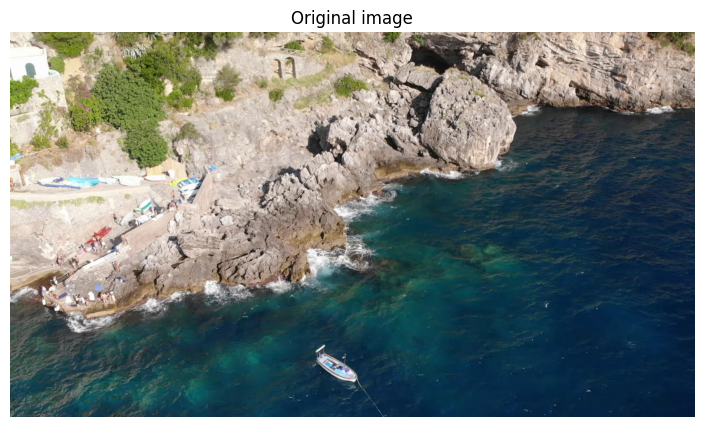

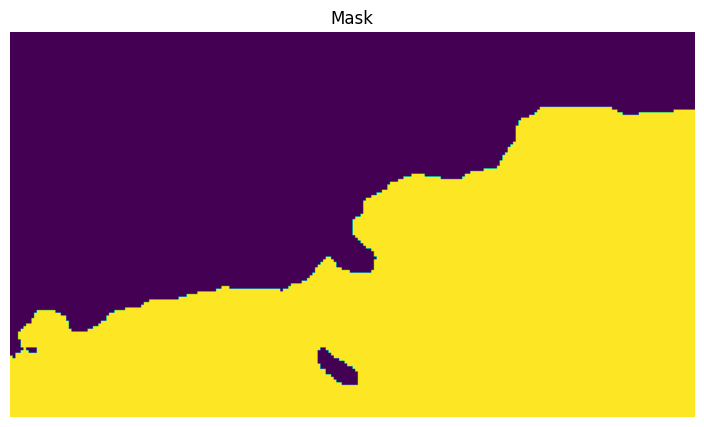

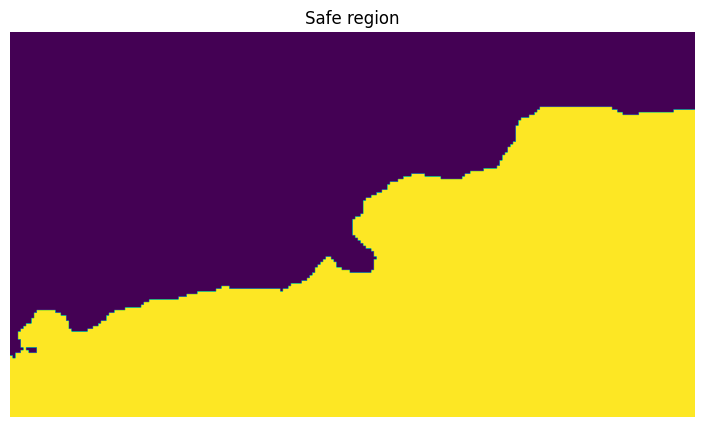

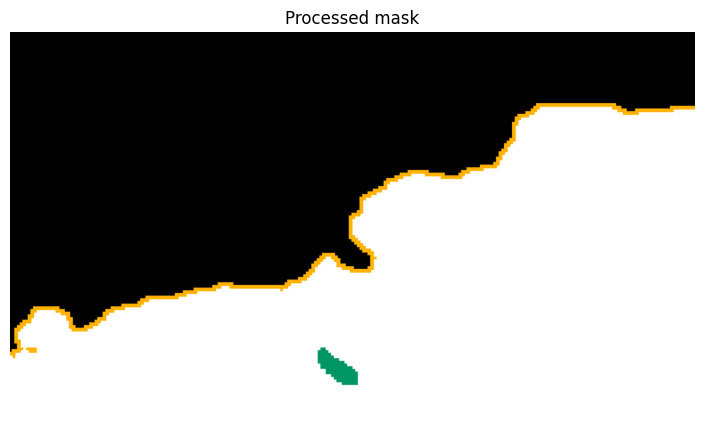

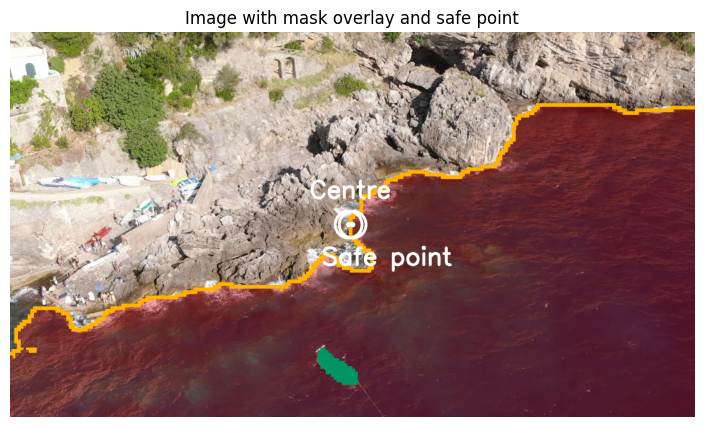

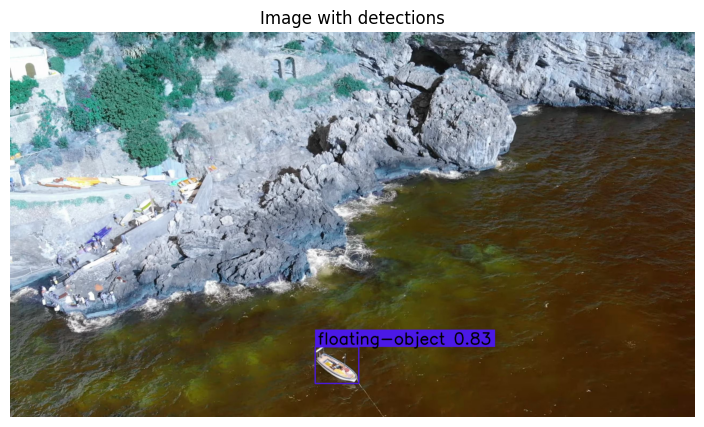

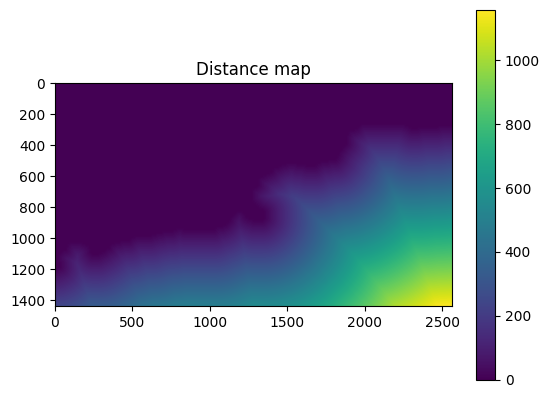

In [2]:
test_img = "/home/emilia/WaterSegNet/test/6.jpg"
# for i in range(1, 21):
#     test_img = f"/home/emilia/WaterSegNet/test/{i}.jpg"
safepoint, mask_image = spf.find_safepoints(
    test_img, show_results=True, padding_factor=30, use_dynamic_points=False
)

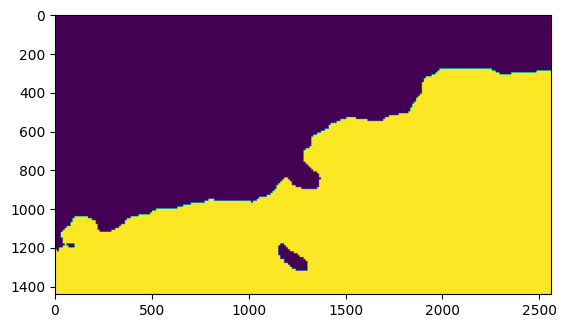

In [3]:
from matplotlib import pyplot as plt

plt.imshow(mask_image)

### Window Sliding Method

Can see that if striding is small, the computation time is large. My method allows to check all pixels, with very low computation time.


In [6]:
from skimage.util import view_as_windows
import numpy as np
import time


def find_safe_areas(image: np.ndarray, window_size: int, stride: int) -> np.ndarray:
    # Define a sliding window of size window_size
    window = np.ones((window_size, window_size), dtype=np.uint8)

    binary_img = np.where(image > 0, 0, 1)  # Invert image and make binary
    center = np.array(binary_img.shape) / 2

    # Crop a subarray centered at the image center and of size window_size times window_size
    center_window = binary_img[
        int(center[0] - window_size / 2) : int(center[0] + window_size / 2),
        int(center[1] - window_size / 2) : int(center[1] + window_size / 2),
    ]

    # Check if the center window is safe
    if np.sum(np.multiply(center_window, window)) == window_size**2:
        return np.array(center)

    # Split the binary image into windows
    windows = view_as_windows(binary_img, window.shape, step=stride)

    safe_loc = []
    for i in range(len(windows)):
        for j in range(len(windows[i])):
            res = np.multiply(windows[i, j], window)
            if np.sum(res) == window_size**2:
                safe_loc.append(
                    [
                        (i * stride) + (window_size // 2),
                        (j * stride) + (window_size // 2),
                    ]
                )

    safe_loc = np.array(safe_loc)

    if len(safe_loc) != 0:
        distances = np.linalg.norm(safe_loc - center, axis=1)
        min_index = np.argmin(distances)
        closest_safe_window = safe_loc[min_index]
        return closest_safe_window
    else:
        return [None]


start_time = time.time()
count = 0
for i in range(1, 21):
    count += 1
    test_img = f"/home/emilia/WaterSegNet/test/{i}.jpg"
    find_safe_areas(mask_image, 40, 2)
end_time = time.time()

Time taken:  3.734082305431366


In [10]:
print("Time taken: ", (end_time - start_time) / count)

Time taken:  3.7340806126594543
